# Particle-In-Cell (PIC) Simulation of Electron and Ion Dynamics with Energy Conservation Analysis

This Jupyter Notebook implements a Particle-In-Cell (PIC) simulation to study the dynamics of electrons and ions in a 2D space. The simulation includes the following key components:

1. **Initialization**: 
   - Physical constants are defined, such as the Boltzmann constant, permittivity of free space, charge of an electron, and masses of electrons and ions.

2. **Poisson Solver**:
   - The `poisson_solver` function calculates the particle number density on a grid, solves Poisson's equation to obtain the electric potential, and derives the electric field from the potential.

3. **Boris Push**:
   - The `boris_push` function performs the Boris algorithm to update the positions and velocities of particles in the presence of electric and magnetic fields.

4. **Energy Calculation**:
   - The `calculate_energy` function computes the kinetic and potential energy of the system to monitor energy conservation during the simulation.

5. **Main Simulation Loop**:
   - Simulation parameters are set, including the number of particles, grid dimensions, simulation time, time step, and initial perturbations.
   - The main function initializes particle positions and velocities, constructs gradient and Laplacian matrices, and iteratively updates the system using the Boris push and Poisson solver.
   - It also stores the total energy at each time step for analysis.

7. **Animation and Energy Plot**:
   - The simulation results are visualized using `matplotlib.animation` to create a GIF showing the particle trajectories.
   - The total energy of the system is plotted over time to analyze energy conservation.
  
The necessary dependencies for this simulation can be found in the file `requirements.txt`

In [13]:
# Import all necessary dependencies
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import matplotlib.animation as animation  # Import the animation module

# Initialize physical constants
k_B       = 1.38e-23   # [J/K]
epsilon_0 = 8.854e-12  # [F/m]
qel       = 1.602e-19  # [C]
qion      = 1.602e-19  # [C] (assuming singly charged ions)
mel       = 9.11e-31   # [kg] (electron mass)
mion      = 1.67e-27   # [kg] (ion mass, e.g., proton)

In [14]:
def poisson_solver_SOR(r_e, r_i, Nx, Ny, Lx, Ly, n0, qel, qion, omega=1.83, tol=1e-5, max_iter=10000):
    """
    Solves Poisson's equation using the Successive Over-Relaxation (SOR) method.
    """
    # Define the measures necessary for interpolation of the particle number density and electric fields
    dx = Lx / Nx        # x bins length [m]
    dy = Ly / Ny        # y bins length [m]

    def interpolate_density(r, charge):
        N = r.shape[0]  # Number of particles
        jx = np.floor(r[:, 0] / dx).astype(int) # x indices
        jy = np.floor(r[:, 1] / dy).astype(int) # y indices

        jx_plus = jx + 1
        jy_plus = jy + 1

        # Boundary conditions
        jx_plus = jx_plus % Nx
        jy_plus = jy_plus % Ny

        # Weights for interpolation
        wjx      = (jx_plus * dx - r[:, 0]) / dx
        wjx_plus = (r[:, 0] - jx * dx) / dx
        wjy      = (jy_plus * dy - r[:, 1]) / dy
        wjy_plus = (r[:, 1] - jy * dy) / dy
        
        # Initialize the grid
        n = np.zeros((Nx, Ny))

        # Loop to calculate the density values
        for i in range(N):
            n[jx[i], jy[i]]           += wjx[i] * wjy[i]
            n[jx_plus[i], jy[i]]      += wjx_plus[i] * wjy[i]
            n[jx[i], jy_plus[i]]      += wjx[i] * wjy_plus[i]
            n[jx_plus[i], jy_plus[i]] += wjx_plus[i] * wjy_plus[i]

        n *= n0 * Lx * Ly / N / (dx * dy) * charge
        return n

    # Interpolate densities for electrons and ions
    n_e = interpolate_density(r_e, -qel)
    n_i = interpolate_density(r_i, qion)
    
    # Total charge density
    rho = n_e + n_i

    # Initialize potential grid with zeros
    pot_grid = np.zeros((Nx, Ny))

    # SOR Iterative Update
    for k in range(max_iter):
        max_diff = 0
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                # Calculate the new potential using SOR formula
                new_pot = (1 - omega) * pot_grid[i, j] + omega * 0.25 * (
                    pot_grid[i+1, j] + pot_grid[i-1, j] + pot_grid[i, j+1] + pot_grid[i, j-1] - dx**2 * rho[i, j] / epsilon_0
                )
                # Calculate the difference for convergence check
                diff = abs(new_pot - pot_grid[i, j])
                max_diff = max(max_diff, diff)
                pot_grid[i, j] = new_pot
        
        # Check for convergence
        if max_diff < tol:
            print(f'Converged after {k} iterations')
            break

    # Get the electric field from -dpot/dr = E
    Ex_grid = np.zeros_like(pot_grid)
    Ey_grid = np.zeros_like(pot_grid)
    Ex_grid[1:-1, 1:-1] = -(pot_grid[2:, 1:-1] - pot_grid[:-2, 1:-1]) / (2 * dx)
    Ey_grid[1:-1, 1:-1] = -(pot_grid[1:-1, 2:] - pot_grid[1:-1, :-2]) / (2 * dy)

    def interpolate_field(r, Ex_grid, Ey_grid):
        jx = np.floor(r[:, 0] / dx).astype(int)
        jy = np.floor(r[:, 1] / dy).astype(int)
        jx_plus = jx + 1
        jy_plus = jy + 1
        jx_plus = jx_plus % Nx
        jy_plus = jy_plus % Ny
        wjx      = (jx_plus * dx - r[:, 0]) / dx
        wjx_plus = (r[:, 0] - jx * dx) / dx
        wjy      = (jy_plus * dy - r[:, 1]) / dy
        wjy_plus = (r[:, 1] - jy * dy) / dy

        Ex = wjx * wjy * Ex_grid[jx, jy] + wjx_plus * wjy * Ex_grid[jx_plus, jy] + wjx * wjy_plus * Ex_grid[jx, jy_plus] + wjx_plus * wjy_plus * Ex_grid[jx_plus, jy_plus]
        Ey = wjx * wjy * Ey_grid[jx, jy] + wjx_plus * wjy * Ey_grid[jx_plus, jy] + wjx * wjy_plus * Ey_grid[jx, jy_plus] + wjx_plus * wjy_plus * Ey_grid[jx_plus, jy_plus]

        return np.column_stack((Ex, Ey))

    E_e = interpolate_field(r_e, Ex_grid, Ey_grid)
    E_i = interpolate_field(r_i, Ex_grid, Ey_grid)

    return E_e, E_i, pot_grid

In [15]:
def boris_push(r, v, E, Bz, q, m, dt, Lx, Ly):
    """
    Perform the Boris push to update the positions and velocities of particles.
    """

    # First half drift
    r += 0.5 * v * dt
    
    # Calculate the electric field acceleration
    a = q * E / m

    # First half electric field acceleration
    v += a * dt / 2.0

    # Boris rotation for magnetic field
    t_x = q * Bz * dt / (2.0 * m)
    t_y = -t_x
    s = 2 * t_x / (1 + t_x * t_x + t_y * t_y)
    v_prime_x = v[:, 0] + v[:, 1] * t_x
    v_prime_y = v[:, 1] - v[:, 0] * t_y
    v[:, 0] += v_prime_y * s
    v[:, 1] += v_prime_x * s

    # Second half electric field acceleration
    v += a * dt / 2.0

    # Second half drift
    r += 0.5 * v * dt

    # Boundary conditions
    r[:, 0] = r[:, 0] % Lx
    r[:, 1] = r[:, 1] % Ly

    # Return position and velocity
    return r, v

In [16]:
def calculate_energy(r_e, v_e, r_i, v_i, pot_grid, qel, qion, mel, mion, dx, dy, E_constant=False):
    """
    Calculate the total energy of the system (kinetic + potential).
    """
    # Kinetic energy
    KE_e = 0.5 * mel * np.sum(v_e**2)
    KE_i = 0.5 * mion * np.sum(v_i**2)
    KE = KE_e + KE_i

    if E_constant == True:
        PE = q * np.sum(E[0] * r[:, 0] + E[1] * r[:, 1])
    else:
        # Interpolate potential energy at particle positions
        jx_e = np.floor(r_e[:, 0] / dx).astype(int)
        jy_e = np.floor(r_e[:, 1] / dy).astype(int)
        jx_i = np.floor(r_i[:, 0] / dx).astype(int)
        jy_i = np.floor(r_i[:, 1] / dy).astype(int)
        
        PE_e = qel * np.sum(pot_grid[jx_e, jy_e])
        PE_i = qion * np.sum(pot_grid[jx_i, jy_i])
        PE = PE_e + PE_i

    # Total energy
    total_energy = KE + PE
    
    return total_energy

MovieWriter imagemagick unavailable; using Pillow instead.


Converged after 1080 iterations
Converged after 1114 iterations
Converged after 1060 iterations
Converged after 1137 iterations
Converged after 983 iterations
Converged after 1135 iterations
Converged after 1116 iterations
Converged after 1056 iterations
Converged after 1035 iterations
Converged after 1032 iterations
Converged after 1121 iterations
Converged after 1143 iterations
Converged after 1058 iterations
Converged after 1112 iterations
Converged after 1134 iterations
Converged after 1143 iterations
Converged after 1108 iterations
Converged after 1114 iterations
Converged after 1153 iterations
Converged after 1134 iterations
Converged after 1066 iterations
Converged after 998 iterations
Converged after 1151 iterations
Converged after 1189 iterations
Converged after 1096 iterations
Converged after 1147 iterations
Converged after 1131 iterations
Converged after 1070 iterations
Converged after 1223 iterations
Converged after 1076 iterations
Converged after 1112 iterations
Converged 

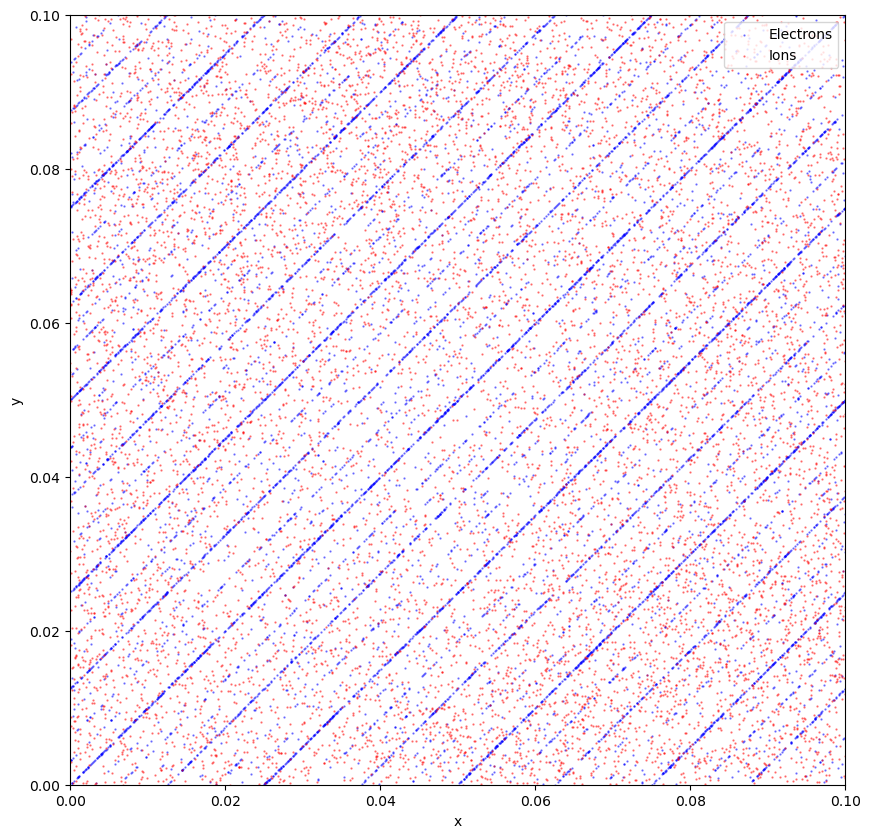

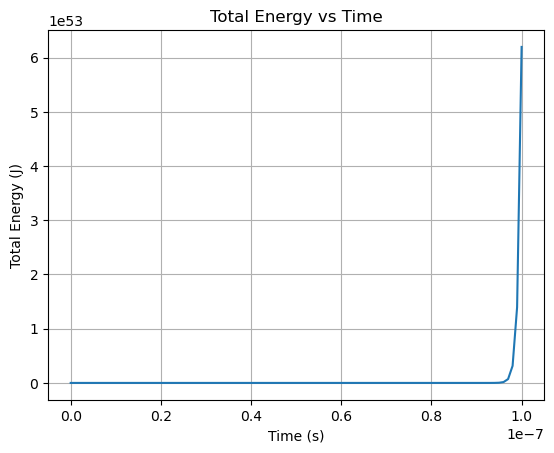

In [17]:
# Main PIC Simulation Loop
def main():
    # Simulation parameters
    N  = 10000      # Number of electrons
    Ni = 10000      # Number of ions
    Nx = 50       # Grid cells in x direction
    Ny = 50       # Grid cells in y direction
    te = 1e-7     # Simulation time [s]
    dt = 1e-9     # Time step [s]
    Lx = 0.1      # Length in x direction [m]
    Ly = 0.1      # Length in y direction [m]
    dx = Lx / Nx  # Position step in x direction [m]
    dy = Ly / Ny  # Position step in y direction [m]
    n0 = 1e16     # Particle number density [1/m^3]
    Bz = 0.1      # Magnetic field [T]
    Te = 1e5      # Electrons temperature [K]
    Ti = 1e4      # Ions Temperature [K]
    A  = 0.1      # Perturbation

    # Calculate the initial velocity Gaussian distribution for the velocity
    ve_std = np.sqrt(k_B * Te / mel) # Thermal velocity of electrons [m/s]
    vi_std = np.sqrt(k_B * Ti / mion) # Thermal velocity of ions [m/s]
    ve = ve_std * np.random.randn(N, 2)
    vi = vi_std * np.random.randn(Ni, 2)

    # Distribute the particles uniformly across the grid
    re = np.random.rand(N, 2) * np.array([Lx, Ly])
    ri = np.random.rand(Ni, 2) * np.array([Lx, Ly])

    # Add perturbation to the velocity
    ve[:, 0] *= (1 + A * np.sin(2 * np.pi * re[:, 0] / Lx))
    ve[:, 1] *= (1 + A * np.sin(2 * np.pi * re[:, 1] / Ly))
    vi[:, 0] *= (1 + A * np.sin(2 * np.pi * ri[:, 0] / Lx))
    vi[:, 1] *= (1 + A * np.sin(2 * np.pi * ri[:, 1] / Ly))

    # Get initial electric field and potential grid
    E_e, E_i, pot_grid = poisson_solver_SOR(re, ri, Nx, Ny, Lx, Ly, n0, qel, qion, omega=1.5, tol=1e-5, max_iter=10000)

    # Number of time steps
    Nt = int(np.ceil(te / dt))

    # List to store energy values
    energies = []

    # Prep figure
    fig, ax = plt.subplots(figsize=(10, 10))

    def update(frame):
        nonlocal re, ve, ri, vi, E_e, E_i, pot_grid

        # Calculate electric field
        E = E_e + E_i

        # Use Boris push to update r and v
        re, ve = boris_push(re, ve, E, Bz, qel, mel, dt, Lx, Ly)
        ri, vi = boris_push(ri, vi, E, Bz, qion, mion, dt, Lx, Ly)

        # Update electric field and potential grid
        E_e, E_i, pot_grid = poisson_solver_SOR(re, ri, Nx, Ny, Lx, Ly, n0, qel, qion, omega=1.5, tol=1e-5, max_iter=10000)

        # Calculate energy
        total_energy = calculate_energy(re, ve, ri, vi, pot_grid, qel, qion, mel, mion, dx, dy)
        energies.append(total_energy)

        # Clear the plot
        ax.cla()
        # Plot electrons and ions
        ax.scatter(re[:, 0], re[:, 1], s=0.4, c='b', alpha=0.5, label='Electrons')
        ax.scatter(ri[:, 0], ri[:, 1], s=0.4, c='r', alpha=0.5, label='Ions')
        ax.axis([0, Lx, 0, Ly])

        # Set legend with specific opacity
        legend = ax.legend(loc='upper right')
        legend.set_alpha(0.3)  # Set the opacity of the legend

        ax.set_xlabel('x')
        ax.set_ylabel('y')

    # Create an animation
    ani = animation.FuncAnimation(fig, update, frames=Nt, repeat=False)

    # Save the animation as a GIF with lower fps to slow it down
    ani.save('pic_simulation.gif', writer='imagemagick', fps=10)

    plt.show()

    # Ensure energies and time array have the same length
    energies = np.array(energies)
    time_array = np.arange(len(energies)) * dt

    # Plot energy vs time
    plt.figure()
    plt.plot(time_array, energies)
    plt.xlabel('Time (s)')
    plt.ylabel('Total Energy (J)')
    plt.title('Total Energy vs Time')
    plt.grid(True)
    plt.savefig('energy_vs_time.png')
    plt.show()

if __name__ == "__main__":
    main()